> Note: The ray-tracing functionalities are not available on Colab. This entire notebook **MUST** be run locally. Besides this notebook, you can also find the latest SAPIEN tutorial at [SAPIEN's documentation](https://sapien.ucsd.edu/docs/latest/index.html).

# Rendering Tutorial 2: Ray Tracing Renderer

In this tutorial, you will learn the following:

- Use ray tracing in `SapienRenderer`

## Preparation

In [ ]:
%pip install sapien

import sapien.core as sapien
import numpy as np
from transforms3d.euler import euler2quat
from PIL import Image

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    raise RuntimeError("This notebook cannot be run on Colab! You need to run it locally with a GPU.")

## Ray tracing vs. rasterization

In the previous tutorials, we have learned how to set up a basic scene with SAPIEN and acquire rendering results under the default settings using SapienRenderer. By default, SapienRenderer uses a high-efficiency rasterization-based rendering pipeline, making it suitable for data-intensive tasks such as reinforcement learning.

However, though fast, the rasterization-based renderer is not physically-grounded, and cannot faithfully model many real-world effects, e.g., indirect lighting, realistic shadows, reflections and refractions, making the results overly flat and lack realism. On the other end, ray tracing renderer simulates how light rays interact with objects in a physically correct manner, and produces images that can be indistinguishable from those captured by a camera.

<p align="center">
    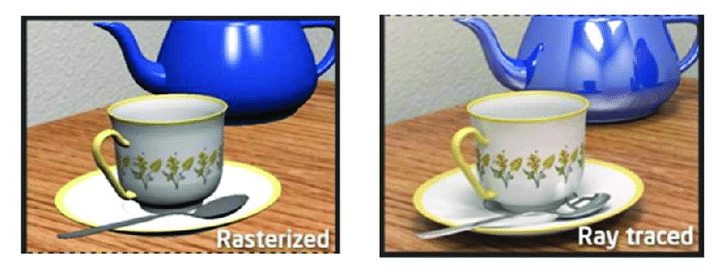
</p>

<div style="text-align: center;"><em>From A Shader-Based Ray Tracing Engine, Park et al.</em></div>

## Ray tracing with SAPIEN

To use the ray-tracing pipeline, simply add the following lines before creating a camera or a viewer:

In [ ]:
sapien.render_config.camera_shader_dir = "rt" # This line will enable camera for ray tracing
sapien.render_config.viewer_shader_dir = "rt" # This line will enable camera for viewer

That’s it! Now you can run everything that you were able to run with ray tracing. But here for demonstration purpose, let us also configure the ray-tracing renderer a bit. We will get into the meaning of the following configurations soon so you don't have to worry about their meaning for now.

In [ ]:
sapien.render_config.rt_samples_per_pixel = 4
sapien.render_config.rt_use_denoiser = False

Let's visualize the object in *Rendering Tutorial 1: camera* again but with ray tracing enabled this time.

In [ ]:
engine = sapien.Engine()
renderer = sapien.SapienRenderer()
engine.set_renderer(renderer)

scene = engine.create_scene()
scene.set_timestep(1 / 100.0)

urdf_path = "../assets/179/mobility.urdf"
loader = scene.create_urdf_loader()
loader.fix_root_link = True
asset = loader.load_kinematic(urdf_path)

scene.set_ambient_light([0.5, 0.5, 0.5])
scene.add_directional_light([0, 1, -1], [0.5, 0.5, 0.5], shadow=True)
scene.add_point_light([1, 2, 2], [1, 1, 1], shadow=True)
scene.add_point_light([1, -2, 2], [1, 1, 1], shadow=True)
scene.add_point_light([-1, 0, 1], [1, 1, 1], shadow=True)

near, far = 0.1, 100
width, height = 640, 480
camera_mount_actor = scene.create_actor_builder().build_kinematic()
camera = scene.add_mounted_camera(
    name="camera",
    actor=camera_mount_actor,
    pose=sapien.Pose(),  # relative to the mounted actor
    width=width,
    height=height,
    fovy=np.deg2rad(35),
    near=near,
    far=far,
)

# Compute the camera pose by specifying forward(x), left(y) and up(z)
cam_pos = np.array([-2, -2, 3])
forward = -cam_pos / np.linalg.norm(cam_pos)
left = np.cross([0, 0, 1], forward)
left = left / np.linalg.norm(left)
up = np.cross(forward, left)
mat44 = np.eye(4)
mat44[:3, :3] = np.stack([forward, left, up], axis=1)
mat44[:3, 3] = cam_pos
camera_mount_actor.set_pose(sapien.Pose.from_transformation_matrix(mat44))

scene.step()  # make everything set
scene.update_render()
camera.take_picture()

rgba = camera.get_float_texture('Color')  # [H, W, 4]
rgba_img = (rgba * 255).clip(0, 255).astype("uint8")
Image.fromarray(rgba_img)

You may find that the result looks more realistic with the ray tracing shader. However the result contains noise due to under-sampling. To reduce the noise, one way is to increase the sample-per-pixel for the renderer. To achieve this, simply change the `rt_samples_per_pixel` in `render_config`. Let's change it to a higher value and render again:

In [ ]:
sapien.render_config.rt_samples_per_pixel = 32

# Newly created camera/viewer will reflect the change in config
camera2 = scene.add_mounted_camera(
    name="camera2",
    actor=camera_mount_actor,
    pose=sapien.Pose(),  # relative to the mounted actor
    width=width,
    height=height,
    fovy=np.deg2rad(35),
    near=near,
    far=far,
)

scene.step()
scene.update_render()
camera2.take_picture()

rgba = camera2.get_float_texture('Color')  # [H, W, 4]
rgba_img = (rgba * 255).clip(0, 255).astype("uint8")
Image.fromarray(rgba_img)

Increasing the spp will affect the rendering speed directly. A cheaper way to reduce the noise is using a denoiser. SapienRenderer supports the OptiX denoiser on NVIDIA RTX GPUs. This time, let's try fix the `rt_samples_per_pixel` at `4` and change `rt_use_denoiser` to True.

In [ ]:
sapien.render_config.rt_samples_per_pixel = 4
sapien.render_config.rt_use_denoiser = True

# Newly created camera/viewer will reflect the change in config
camera3 = scene.add_mounted_camera(
    name="camera3",
    actor=camera_mount_actor,
    pose=sapien.Pose(),  # relative to the mounted actor
    width=width,
    height=height,
    fovy=np.deg2rad(35),
    near=near,
    far=far,
)

scene.step()
scene.update_render()
camera3.take_picture()

rgba = camera3.get_float_texture('Color')  # [H, W, 4]
rgba_img = (rgba * 255).clip(0, 255).astype("uint8")
Image.fromarray(rgba_img)

> Note: You are required to have an NVIDIA RTX GPU with driver version >= 522 installed to use the denoiser. While you may get the denoiser to work on drivers of lower versions, it is not officially supported.

## Reflection and refraction

Ray tracing allows SAPIEN to render realistic reflection and refractions.

We will create a scene in SAPIEN and render with ray tracing turned off and on. First, let's set up the environment:

In [ ]:
scene2 = engine.create_scene()

ground_material = renderer.create_material()
ground_material.base_color = np.array([202, 164, 114, 256]) / 256
ground_material.specular = 0.5
scene2.add_ground(0, render_material=ground_material)
scene2.set_timestep(1 / 240)

scene2.set_ambient_light([0.3, 0.3, 0.3])
scene2.add_directional_light(
    [0, 0.5, -1], color=[3.0, 3.0, 3.0],
    shadow=True, scale=2.0, shadow_map_size=4096  # these are only needed for rasterization
)

Next, let’s build the scene. First, we create a rough bluish sphere:

In [ ]:
builder = scene2.create_actor_builder()
material = renderer.create_material()
material.base_color = [0.2, 0.2, 0.8, 1.0]
material.roughness = 0.5
material.metallic = 0.0
builder.add_sphere_visual(radius=0.06, material=material)
builder.add_sphere_collision(radius=0.06)
sphere1 = builder.build()
sphere1.set_pose(sapien.Pose(p=[-0.05, 0.05, 0.06]))

Next, we create a rough transparent sphere:

In [ ]:
builder = scene2.create_actor_builder()
material = renderer.create_material()
material.ior = 1.2
material.transmission = 1.0
material.base_color = [1.0, 1.0, 1.0, 1.0]
material.roughness = 0.15
material.metallic = 0.0
builder.add_sphere_visual(radius=0.07, material=material)
builder.add_sphere_collision(radius=0.07)
sphere2 = builder.build()
sphere2.set_pose(sapien.Pose(p=[0.05, -0.05, 0.07]))

Generally, setting a large transmission value will lead to a transparent material. Similarly, we can add a capsule and a box with complex materials:

In [ ]:
builder = scene2.create_actor_builder()
material = renderer.create_material()
material.base_color = [0.8, 0.7, 0.1, 1.0]
material.roughness = 0.01
material.metallic = 1.0
builder.add_capsule_visual(radius=0.02, half_length=0.1, material=material)
builder.add_capsule_collision(radius=0.02, half_length=0.1)
cap = builder.build()
cap.set_pose(sapien.Pose(p=[0.15, -0.01, 0.01], q=euler2quat(0, 0, -0.7)))

builder = scene2.create_actor_builder()
material = renderer.create_material()
material.base_color = [0.8, 0.2, 0.2, 1.0]
material.roughness = 0.005
material.metallic = 1.0
builder.add_box_visual(half_size=[0.09, 0.09, 0.09], material=material)
builder.add_box_collision(half_size=[0.09, 0.09, 0.09])
box = builder.build()
box.set_pose(sapien.Pose(p=[0.05, 0.17, 0.09]))

Finally, let’s load an external mesh and assign a highly metallic material to that object:

In [ ]:
builder = scene2.create_actor_builder()
material = renderer.create_material()
material.base_color = [0.9, 0.6, 0.5, 1.0]
material.roughness = 0.0
material.metallic = 1.0
builder.add_visual_from_file(
    '../assets/suzanne.dae', scale=[0.1, 0.1, 0.1], material=material)
builder.add_box_collision(half_size=[0.1, 0.1, 0.1])
box = builder.build()
box.set_pose(sapien.Pose(p=[0.15, -0.25, 0.1], q=euler2quat(0, 0, -1)))

Now let's add a camera to the scene and see how the rendering result looks like. Let's start with the result with ray tracing turned off:

In [ ]:
sapien.render_config.camera_shader_dir = "ibl" # Use default rasterization renderer for camera
sapien.render_config.viewer_shader_dir = "ibl" # Use default rasterization renderer for viewer

camera_mount_actor2 = scene2.create_actor_builder().build_kinematic()
camera_ibl = scene2.add_mounted_camera(
    name="camera_ibl",
    actor=camera_mount_actor2,
    pose=sapien.Pose(),  # relative to the mounted actor
    width=1280,
    height=720,
    fovy=np.deg2rad(45),
    near=0.1,
    far=100,
)

camera_mount_actor2.set_pose(
    sapien.Pose([-0.28, -0.28, 0.46], [0.8876263, -0.135299, 0.3266407, 0.2951603]))

scene2.step()
scene2.update_render()
camera_ibl.take_picture()

rgba = camera_ibl.get_float_texture('Color')  # [H, W, 4]
rgba_img = (rgba * 255).clip(0, 255).astype("uint8")
Image.fromarray(rgba_img)

The default rasterization renderer cannot handle objects with complicated optical properties. Now let's change our renderer to ray-tracing renderer and see how will the result be like:

In [ ]:
sapien.render_config.camera_shader_dir = "rt" # Use ray tracing renderer for camera
sapien.render_config.viewer_shader_dir = "rt" # Use ray tracing renderer for viewer
sapien.render_config.rt_samples_per_pixel = 32
sapien.render_config.rt_use_denoiser = True

# Newly created camera/viewer will reflect the change in config
camera_rt = scene2.add_mounted_camera(
    name="camera_rt",
    actor=camera_mount_actor2,
    pose=sapien.Pose(),  # relative to the mounted actor
    width=1280,
    height=720,
    fovy=np.deg2rad(45),
    near=0.1,
    far=100,
)

scene2.step()
scene2.update_render()
camera_rt.take_picture()

rgba = camera_rt.get_float_texture('Color')  # [H, W, 4]
rgba_img = (rgba * 255).clip(0, 255).astype("uint8")
Image.fromarray(rgba_img)